In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers
from keras import Model
from keras import Input
from keras.utils import plot_model
from keras.layers import concatenate

import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load
from keras.models import load_model
import seaborn as sb
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

# comment the below line if you not using jupyter notebook
%matplotlib inline

In [2]:
print("Started reading the data for training...")
df_ = pd.read_csv('train.csv')
df = df_.copy()
# df_training = df.iloc[:,:].copy()
print("Finished reading the data")

Started reading the data for training...
Finished reading the data


In [3]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['color_type'])
df['color_type'] = le.transform(df['color_type'])

In [5]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,18,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,53,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,15,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,53,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,2,0.50,11.06,18,4,0.0,1


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc_y1 = OneHotEncoder(handle_unknown='ignore')
enc_y1.fit(df[['breed_category']])
y1 = enc_y1.transform(df[['breed_category']]).toarray()
enc_y2 = OneHotEncoder(handle_unknown='ignore')
enc_y2.fit(df[['pet_category']])
y2 = enc_y2.transform(df[['pet_category']]).toarray()

In [7]:
df[['condition']] = df[['condition']].fillna(3.0)

In [8]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,18,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,53,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3.0,15,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,53,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,2,0.50,11.06,18,4,0.0,1


In [9]:
x = df[['condition', 'color_type', 'length(m)', 'height(cm)', 'X1', 'X2']].values

In [10]:
def scaleData(x, y):
    sc_x = StandardScaler()
    sc_y = StandardScaler()

    sc_x.fit(x)
    sc_y.fit(y)
    
    return sc_x, sc_y

In [11]:
sc_x, sc_y = scaleData(x,y1)

In [12]:
x_scaled = sc_x.transform(x)

In [13]:
x_train = x_scaled[:,:]
y_train1 = y1[:,:]
y_train2 = y2[:,:]
x_val = x_scaled[15000:,:]
y_val1 = y1[15000:,:]
y_val2 = y2[15000:,:]

In [ ]:
# base = load_model('model_cond-4-64-split_2.h5')

In [100]:
from keras.layers import BatchNormalization

Kreg = regularizers.l2(5e-4)

inp = Input(shape = (x_train.shape[1],), name = 'x')
layer1 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 1), kernel_regularizer = Kreg)(inp)

batch1 = BatchNormalization()(layer1)

layer2 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 2), kernel_regularizer = Kreg)(batch1)

batch2 = BatchNormalization()(layer2)

layer3 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 3), kernel_regularizer = Kreg)(batch2)

batch3 = BatchNormalization()(layer3)

y1 = Dense(3, activation = 'softmax', name = 'y1',
                kernel_initializer = glorot_uniform(seed = 4), kernel_regularizer = Kreg)(batch3)

y2 = Dense(4, activation = 'softmax', name = 'y2',
                kernel_initializer = glorot_uniform(seed = 5), kernel_regularizer = Kreg)(batch3)

model = Model(
    inputs=inp,
    outputs=[y1, y2]
)

# model.load_weights('model_cond-4-64-split_2.h5')

In [101]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           448         x[0][0]                          
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64)           256         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           4160        batch_normalization[0][0]        
____________________________________________________________________________________________

In [169]:
adam = Adam(learning_rate = 0.00001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['categorical_accuracy'])

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('model-12Aug.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)
callbacks = [es, mc]

history = model.fit(
    x = {'x':x_train},
    y = {'y1':y_train1, 'y2':y_train2},
    epochs=10000, batch_size=32,
    validation_data = ({'x':x_val},
                       {'y1':y_val1, 'y2':y_val2}),
    verbose = 1, callbacks = callbacks)

Epoch 1/10000
576/589 [============================>.] - ETA: 0s - loss: 0.4747 - y1_loss: 0.1429 - y2_loss: 0.3154 - y1_categorical_accuracy: 0.9128 - y2_categorical_accuracy: 0.8647
Epoch 00001: loss improved from inf to 0.47444, saving model to model-12Aug.h5
589/589 [==============================] - 3s 4ms/step - loss: 0.4744 - y1_loss: 0.1432 - y2_loss: 0.3148 - y1_categorical_accuracy: 0.9128 - y2_categorical_accuracy: 0.8651 - val_loss: 0.4536 - val_y1_loss: 0.1434 - val_y2_loss: 0.2938 - val_y1_categorical_accuracy: 0.9142 - val_y2_categorical_accuracy: 0.8717
Epoch 2/10000
588/589 [============================>.] - ETA: 0s - loss: 0.4759 - y1_loss: 0.1432 - y2_loss: 0.3163 - y1_categorical_accuracy: 0.9127 - y2_categorical_accuracy: 0.8644
Epoch 00002: loss did not improve from 0.47444
589/589 [==============================] - 2s 3ms/step - loss: 0.4760 - y1_loss: 0.1432 - y2_loss: 0.3164 - y1_categorical_accuracy: 0.9127 - y2_categorical_accuracy: 0.8643 - val_loss: 0.4542 

Epoch 16/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4726 - y1_loss: 0.1436 - y2_loss: 0.3126 - y1_categorical_accuracy: 0.9133 - y2_categorical_accuracy: 0.8662
Epoch 00016: loss did not improve from 0.46855
589/589 [==============================] - 2s 4ms/step - loss: 0.4726 - y1_loss: 0.1436 - y2_loss: 0.3127 - y1_categorical_accuracy: 0.9132 - y2_categorical_accuracy: 0.8662 - val_loss: 0.4528 - val_y1_loss: 0.1432 - val_y2_loss: 0.2932 - val_y1_categorical_accuracy: 0.9134 - val_y2_categorical_accuracy: 0.8727
Epoch 17/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4726 - y1_loss: 0.1438 - y2_loss: 0.3125 - y1_categorical_accuracy: 0.9127 - y2_categorical_accuracy: 0.8660- ETA: 0s - loss: 0.4652 - y1_loss: 0.1432 - y2_loss: 0.3056 - y1_categorical_accuracy: 0.9132 - y2_categorical_accura
Epoch 00017: loss did not improve from 0.46855
589/589 [==============================] - 2s 4ms/step - loss: 0.4729 - y1_loss: 0.1439 - y2_loss: 0.3126

Epoch 31/10000
586/589 [============================>.] - ETA: 0s - loss: 0.4712 - y1_loss: 0.1429 - y2_loss: 0.3119 - y1_categorical_accuracy: 0.9129 - y2_categorical_accuracy: 0.8672
Epoch 00031: loss did not improve from 0.46855
589/589 [==============================] - 2s 3ms/step - loss: 0.4718 - y1_loss: 0.1431 - y2_loss: 0.3123 - y1_categorical_accuracy: 0.9128 - y2_categorical_accuracy: 0.8671 - val_loss: 0.4534 - val_y1_loss: 0.1437 - val_y2_loss: 0.2933 - val_y1_categorical_accuracy: 0.9121 - val_y2_categorical_accuracy: 0.8701
Epoch 32/10000
573/589 [============================>.] - ETA: 0s - loss: 0.4718 - y1_loss: 0.1423 - y2_loss: 0.3131 - y1_categorical_accuracy: 0.9144 - y2_categorical_accuracy: 0.8657
Epoch 00032: loss did not improve from 0.46855
589/589 [==============================] - 2s 3ms/step - loss: 0.4696 - y1_loss: 0.1419 - y2_loss: 0.3114 - y1_categorical_accuracy: 0.9145 - y2_categorical_accuracy: 0.8666 - val_loss: 0.4527 - val_y1_loss: 0.1435 - val_y2

Epoch 46/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4745 - y1_loss: 0.1435 - y2_loss: 0.3147 - y1_categorical_accuracy: 0.9148 - y2_categorical_accuracy: 0.8658
Epoch 00046: loss did not improve from 0.46854
589/589 [==============================] - 2s 3ms/step - loss: 0.4744 - y1_loss: 0.1434 - y2_loss: 0.3146 - y1_categorical_accuracy: 0.9149 - y2_categorical_accuracy: 0.8655 - val_loss: 0.4525 - val_y1_loss: 0.1432 - val_y2_loss: 0.2929 - val_y1_categorical_accuracy: 0.9139 - val_y2_categorical_accuracy: 0.8722
Epoch 47/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4737 - y1_loss: 0.1437 - y2_loss: 0.3136 - y1_categorical_accuracy: 0.9106 - y2_categorical_accuracy: 0.8677
Epoch 00047: loss did not improve from 0.46854
589/589 [==============================] - 2s 3ms/step - loss: 0.4734 - y1_loss: 0.1438 - y2_loss: 0.3132 - y1_categorical_accuracy: 0.9104 - y2_categorical_accuracy: 0.8678 - val_loss: 0.4545 - val_y1_loss: 0.1434 - val_y2

579/589 [============================>.] - ETA: 0s - loss: 0.4726 - y1_loss: 0.1422 - y2_loss: 0.3141 - y1_categorical_accuracy: 0.9106 - y2_categorical_accuracy: 0.8666
Epoch 00061: loss did not improve from 0.46854
589/589 [==============================] - 2s 3ms/step - loss: 0.4732 - y1_loss: 0.1425 - y2_loss: 0.3144 - y1_categorical_accuracy: 0.9103 - y2_categorical_accuracy: 0.8664 - val_loss: 0.4536 - val_y1_loss: 0.1432 - val_y2_loss: 0.2940 - val_y1_categorical_accuracy: 0.9124 - val_y2_categorical_accuracy: 0.8714
Epoch 62/10000
577/589 [============================>.] - ETA: 0s - loss: 0.4725 - y1_loss: 0.1431 - y2_loss: 0.3131 - y1_categorical_accuracy: 0.9134 - y2_categorical_accuracy: 0.8661
Epoch 00062: loss did not improve from 0.46854
589/589 [==============================] - 2s 3ms/step - loss: 0.4728 - y1_loss: 0.1432 - y2_loss: 0.3132 - y1_categorical_accuracy: 0.9135 - y2_categorical_accuracy: 0.8664 - val_loss: 0.4541 - val_y1_loss: 0.1434 - val_y2_loss: 0.2944 -

Epoch 76/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4749 - y1_loss: 0.1437 - y2_loss: 0.3148 - y1_categorical_accuracy: 0.9108 - y2_categorical_accuracy: 0.8651
Epoch 00076: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4741 - y1_loss: 0.1432 - y2_loss: 0.3145 - y1_categorical_accuracy: 0.9112 - y2_categorical_accuracy: 0.8653 - val_loss: 0.4537 - val_y1_loss: 0.1435 - val_y2_loss: 0.2939 - val_y1_categorical_accuracy: 0.9116 - val_y2_categorical_accuracy: 0.8709
Epoch 77/10000
584/589 [============================>.] - ETA: 0s - loss: 0.4720 - y1_loss: 0.1436 - y2_loss: 0.3121 - y1_categorical_accuracy: 0.9144 - y2_categorical_accuracy: 0.8661
Epoch 00077: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4716 - y1_loss: 0.1433 - y2_loss: 0.3119 - y1_categorical_accuracy: 0.9147 - y2_categorical_accuracy: 0.8663 - val_loss: 0.4521 - val_y1_loss: 0.1433 - val_y2

585/589 [============================>.] - ETA: 0s - loss: 0.4727 - y1_loss: 0.1432 - y2_loss: 0.3131 - y1_categorical_accuracy: 0.9142 - y2_categorical_accuracy: 0.8644
Epoch 00091: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4724 - y1_loss: 0.1431 - y2_loss: 0.3129 - y1_categorical_accuracy: 0.9143 - y2_categorical_accuracy: 0.8645 - val_loss: 0.4545 - val_y1_loss: 0.1433 - val_y2_loss: 0.2949 - val_y1_categorical_accuracy: 0.9116 - val_y2_categorical_accuracy: 0.8688
Epoch 92/10000
589/589 [==============================] - ETA: 0s - loss: 0.4712 - y1_loss: 0.1437 - y2_loss: 0.3112 - y1_categorical_accuracy: 0.9122 - y2_categorical_accuracy: 0.8683
Epoch 00092: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4712 - y1_loss: 0.1437 - y2_loss: 0.3112 - y1_categorical_accuracy: 0.9122 - y2_categorical_accuracy: 0.8683 - val_loss: 0.4529 - val_y1_loss: 0.1435 - val_y2_loss: 0.2930 -

577/589 [============================>.] - ETA: 0s - loss: 0.4707 - y1_loss: 0.1434 - y2_loss: 0.3110 - y1_categorical_accuracy: 0.9140 - y2_categorical_accuracy: 0.8697
Epoch 00106: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4714 - y1_loss: 0.1435 - y2_loss: 0.3116 - y1_categorical_accuracy: 0.9141 - y2_categorical_accuracy: 0.8694 - val_loss: 0.4526 - val_y1_loss: 0.1429 - val_y2_loss: 0.2934 - val_y1_categorical_accuracy: 0.9142 - val_y2_categorical_accuracy: 0.8691
Epoch 107/10000
574/589 [============================>.] - ETA: 0s - loss: 0.4758 - y1_loss: 0.1449 - y2_loss: 0.3145 - y1_categorical_accuracy: 0.9126 - y2_categorical_accuracy: 0.8669
Epoch 00107: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4752 - y1_loss: 0.1445 - y2_loss: 0.3143 - y1_categorical_accuracy: 0.9130 - y2_categorical_accuracy: 0.8669 - val_loss: 0.4532 - val_y1_loss: 0.1432 - val_y2_loss: 0.2937 

583/589 [============================>.] - ETA: 0s - loss: 0.4694 - y1_loss: 0.1428 - y2_loss: 0.3103 - y1_categorical_accuracy: 0.9127 - y2_categorical_accuracy: 0.8697
Epoch 00121: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4688 - y1_loss: 0.1429 - y2_loss: 0.3097 - y1_categorical_accuracy: 0.9126 - y2_categorical_accuracy: 0.8702 - val_loss: 0.4536 - val_y1_loss: 0.1432 - val_y2_loss: 0.2941 - val_y1_categorical_accuracy: 0.9137 - val_y2_categorical_accuracy: 0.8691
Epoch 122/10000
582/589 [============================>.] - ETA: 0s - loss: 0.4744 - y1_loss: 0.1438 - y2_loss: 0.3143 - y1_categorical_accuracy: 0.9124 - y2_categorical_accuracy: 0.8679
Epoch 00122: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4745 - y1_loss: 0.1438 - y2_loss: 0.3143 - y1_categorical_accuracy: 0.9124 - y2_categorical_accuracy: 0.8679 - val_loss: 0.4543 - val_y1_loss: 0.1436 - val_y2_loss: 0.2944 

586/589 [============================>.] - ETA: 0s - loss: 0.4745 - y1_loss: 0.1431 - y2_loss: 0.3150 - y1_categorical_accuracy: 0.9138 - y2_categorical_accuracy: 0.8663
Epoch 00136: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4750 - y1_loss: 0.1433 - y2_loss: 0.3154 - y1_categorical_accuracy: 0.9139 - y2_categorical_accuracy: 0.8661 - val_loss: 0.4531 - val_y1_loss: 0.1433 - val_y2_loss: 0.2935 - val_y1_categorical_accuracy: 0.9129 - val_y2_categorical_accuracy: 0.8706
Epoch 137/10000
585/589 [============================>.] - ETA: 0s - loss: 0.4745 - y1_loss: 0.1432 - y2_loss: 0.3149 - y1_categorical_accuracy: 0.9113 - y2_categorical_accuracy: 0.8669
Epoch 00137: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4738 - y1_loss: 0.1429 - y2_loss: 0.3146 - y1_categorical_accuracy: 0.9115 - y2_categorical_accuracy: 0.8669 - val_loss: 0.4537 - val_y1_loss: 0.1431 - val_y2_loss: 0.2943 

575/589 [============================>.] - ETA: 0s - loss: 0.4754 - y1_loss: 0.1445 - y2_loss: 0.3146 - y1_categorical_accuracy: 0.9121 - y2_categorical_accuracy: 0.8639
Epoch 00151: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4757 - y1_loss: 0.1438 - y2_loss: 0.3156 - y1_categorical_accuracy: 0.9129 - y2_categorical_accuracy: 0.8632 - val_loss: 0.4524 - val_y1_loss: 0.1429 - val_y2_loss: 0.2931 - val_y1_categorical_accuracy: 0.9142 - val_y2_categorical_accuracy: 0.8727
Epoch 152/10000
569/589 [===========================>..] - ETA: 0s - loss: 0.4727 - y1_loss: 0.1425 - y2_loss: 0.3138 - y1_categorical_accuracy: 0.9168 - y2_categorical_accuracy: 0.8675
Epoch 00152: loss did not improve from 0.46726
589/589 [==============================] - 2s 3ms/step - loss: 0.4738 - y1_loss: 0.1426 - y2_loss: 0.3149 - y1_categorical_accuracy: 0.9166 - y2_categorical_accuracy: 0.8669 - val_loss: 0.4544 - val_y1_loss: 0.1429 - val_y2_loss: 0.2951 

In [170]:
model = load_model('model-12Aug.h5')

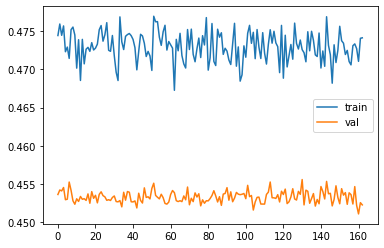

In [171]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

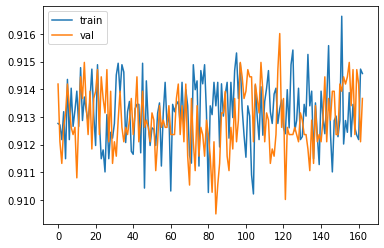

In [172]:
plt.figure()
plt.plot(history.history['y1_categorical_accuracy'], label='train')
plt.plot(history.history['val_y1_categorical_accuracy'], label='val')
plt.legend()
plt.show()

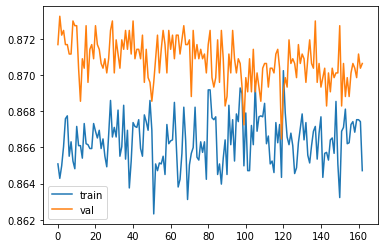

In [173]:
plt.figure()
plt.plot(history.history['y2_categorical_accuracy'], label='train')
plt.plot(history.history['val_y2_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [174]:
ymodel = model.predict(x_val)

In [175]:
ymodel1 = enc_y1.inverse_transform(ymodel[0])
y_act1 = enc_y1.inverse_transform(y_val1)
ymodel2 = enc_y2.inverse_transform(ymodel[1])
y_act2 = enc_y2.inverse_transform(y_val2)

In [176]:
from sklearn.metrics import f1_score

In [177]:
f1 = f1_score(ymodel1[:,0],y_act1[:,0],average='weighted')

In [178]:
f2 = f1_score(ymodel2[:,0],y_act2[:,0],average='weighted')

In [179]:
(f1+f2)*100/2

89.26606459359552

In [157]:
89

89